In [1]:
%cd ..

/Users/pstock/Documents/privacy_lint


In [2]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


import matplotlib.pyplot as plt

from privacy_lint.attack_results import AttackResults
from privacy_lint.attacks.loss import LossAttack
from privacy_lint.attacks.grad_norm import GradNormAttack


%matplotlib inline  
%config InlineBackend.figure_format='retina'

We create a model that learns the mean of a Gaussian. 

In [3]:
n_train = 1000
n_test = 1000
d = 10000

model = nn.Parameter(torch.zeros(1, d))

In [4]:
trainset = TensorDataset(torch.randn(n_train, d))
testset = TensorDataset(torch.randn(n_test, d))

In [5]:
train_loader = DataLoader(trainset, batch_size=n_train)
test_loader = DataLoader(testset, batch_size=n_test)

In [6]:
criterion = nn.MSELoss(reduction='sum')

In [7]:
trainset[0]

(tensor([ 1.1187, -0.0725, -0.2721,  ...,  0.7938,  0.3163, -0.1957]),)

In [8]:
optimizer = optim.SGD([model], lr=1, momentum=0)
for x in train_loader:
    loss = criterion(model.broadcast_to(x[0].size()), x[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Loss attack

In [9]:
@torch.no_grad()
def compute_loss_mse(model, dataloader):
    losses = []
    for x in tqdm(dataloader):
        batch_losses = torch.sum(torch.pow(model - x[0], 2), dim=1)
        losses += batch_losses.tolist()

    return torch.Tensor(losses)

In [10]:
attack = LossAttack(compute_loss=compute_loss_mse)
loss_results = attack.launch(model, train_loader, test_loader)

100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


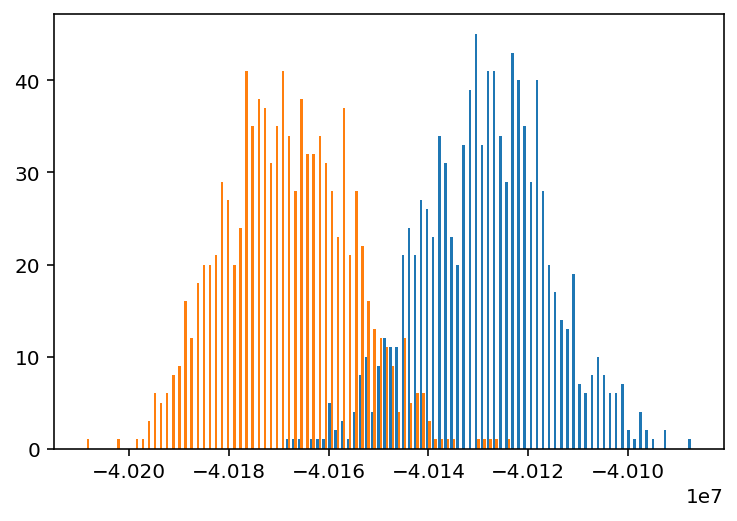

In [11]:
_ = plt.hist([loss_results.scores_train.numpy(), loss_results.scores_test.numpy()], bins=100)

## Gradient norm attack

In [12]:
def compute_grad_norm_mse(model, dataloader):
    norms = []

    for x in tqdm(dataloader):
        for i in range(len(x[0])):
            model.grad.zero_()
            loss = torch.sum(torch.pow(model - x[0][i], 2), dim=1)
            loss.backward()

            #norms.append(model.grad.norm(p=2)**2)
            norms.append(torch.sum(torch.pow(model.grad, 2)))

    return torch.Tensor(norms)


In [13]:
attack = GradNormAttack(compute_grad_norm=compute_grad_norm_mse)
grad_results = attack.launch(model, train_loader, test_loader)

100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


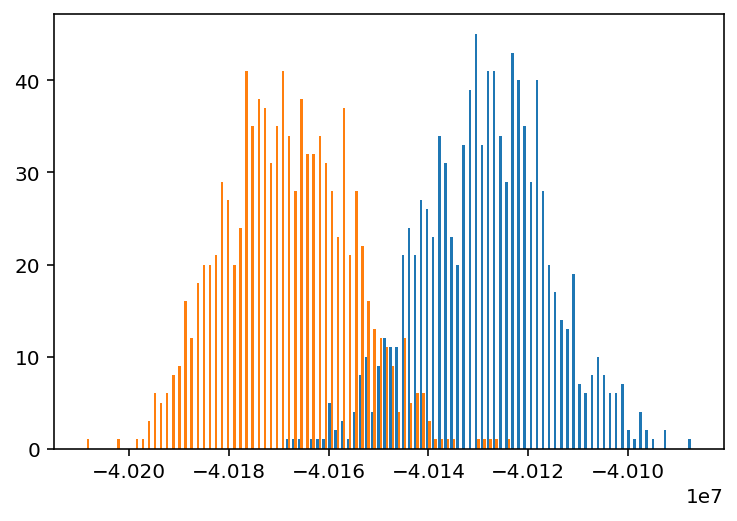

In [14]:
_ = plt.hist([grad_results.scores_train.numpy() / 4, grad_results.scores_test.numpy() / 4], bins=100)

In [15]:
print(grad_results.scores_train[:10] / 4)
print(loss_results.scores_train[:10])

tensor([-40124584., -40117656., -40122104., -40141004., -40116120., -40148272.,
        -40123768., -40115320., -40137056., -40117876.])
tensor([-40124584., -40117656., -40122104., -40141004., -40116120., -40148272.,
        -40123768., -40115320., -40137056., -40117876.])


## Group attacks

In a group attack, we know that all samples from the group come from either the train or the test set. This yields better results

In [16]:
results = grad_results.group(group_size=10, num_groups=1000)

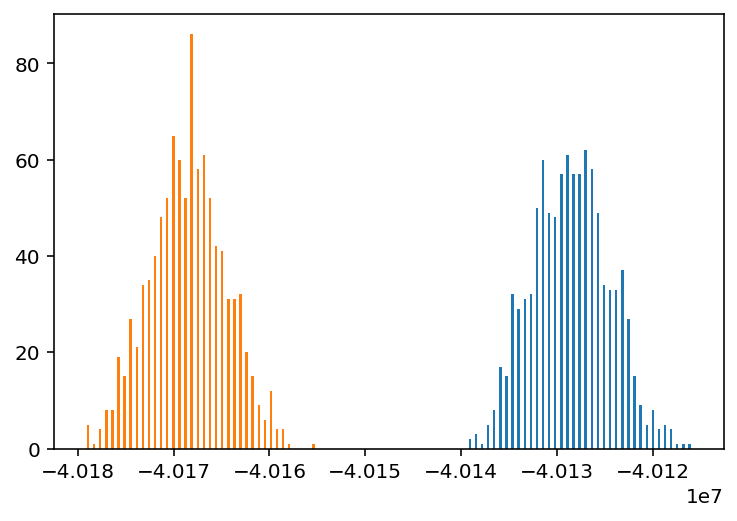

In [17]:
_ = plt.hist([results.scores_train.numpy() / 4, results.scores_test.numpy() / 4], bins=100)